In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

In [3]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros((T_inbound, headings.shape[1]))), axis=0)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros((T_inbound, flow.shape[1]))), axis=0)


######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


In [4]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [5]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms, name='h_stimulus')
P_HEADING = PoissonGroup(N_TL2, rates=h_stimulus[0,:], name='P_HEADING')

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms, name='h_stimulus')
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)', name='P_FLOW')

global CPU4_memory_stimulus
CPU4_memory_stimulus = CPU_MEMORY_starting_value*np.ones((T,N_CPU4))
CPU4_stimulus = TimedArray(CPU4_memory_stimulus*Hz, dt=1.*time_step*ms, name='CPU4_stimulus')
P_CPU4_MEMORY = PoissonGroup(N_CPU4, rates='CPU4_stimulus(t,i)', name='P_CPU4_MEMORY')

In [6]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1')
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params, name='TN2')
G_CPU4 = nc.generate_neuron_groups(N_CPU4, eqs, threshold_eqs, reset_eqs, CPU4_neuron_params, name='CPU4')
G_CPU1A = nc.generate_neuron_groups(N_CPU1A, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1A')
G_CPU1B = nc.generate_neuron_groups(N_CPU1B, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1B')
G_PONTINE = nc.generate_neuron_groups(N_PONTINE, eqs, threshold_eqs, reset_eqs, neuron_params, name='PONTINE')
G_MOTOR = nc.generate_neuron_groups(N_MOTOR, eqs, threshold_eqs, reset_eqs, neuron_params, name='MOTOR')

In [7]:
SPM_HEADING = SpikeMonitor(P_HEADING, name='SPM_HEADING')
SPM_FLOW = SpikeMonitor(P_FLOW, name='SPM_FLOW')
SPM_CPU4_MEMORY = SpikeMonitor(P_CPU4_MEMORY, name='SPM_P_CPU4_MEMORY')

SPM_TL2 = SpikeMonitor(G_TL2, name='SPM_TL2')
SPM_CL1 = SpikeMonitor(G_CL1, name='SPM_CL1')
SPM_TB1 = SpikeMonitor(G_TB1, name='SPM_TB1')
SPM_TN2 = SpikeMonitor(G_TN2, name='SPM_TN2')
SPM_CPU4 = SpikeMonitor(G_CPU4, name='SPM_CPU4')
SPM_CPU1A = SpikeMonitor(G_CPU1A, name='SPM_CPU1A')
SPM_CPU1B = SpikeMonitor(G_CPU1B, name='SPM_CPU1B')
SPM_PONTINE = SpikeMonitor(G_PONTINE, name='SPM_PONTINE')
SPM_MOTOR = SpikeMonitor(G_MOTOR, name='SPM_MOTOR')

In [8]:
# Inputs
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, params=H_TL2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_HEADING_TL2')
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, params=F_TN2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_FLOW_TN2')

# TL2
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex, name='S_TL2_CL1')

# CL1
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex, name='S_CL1_TB1')

# TN2
S_TN2_CPU4 = nc.connect_synapses(G_TN2, G_CPU4, W_TN2_CPU4, model=synapses_model, params=TN2_CPU4_synapses_params, on_pre=synapses_eqs_ex, name='S_TN2_CPU4')

# TB1
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in, name='S_TB1_TB1')
S_TB1_CPU4 = nc.connect_synapses(G_TB1, G_CPU4, W_TB1_CPU4, model=synapses_model, params=TB1_CPU4_synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU4')
S_TB1_CPU1A = nc.connect_synapses(G_TB1, G_CPU1A, W_TB1_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU1A')
S_TB1_CPU1B = nc.connect_synapses(G_TB1, G_CPU1B, W_TB1_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_TB1_CPU1B')

# CPU4 population
#S_CPU4_PONTINE = nc.connect_synapses(G_CPU4, G_PONTINE, W_CPU4_PONTINE, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_PONTINE')
#S_CPU4_CPU1A = nc.connect_synapses(G_CPU4, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_CPU1A')
#S_CPU4_CPU1B = nc.connect_synapses(G_CPU4, G_CPU1B, W_CPU4_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_CPU1B')

# CPU4 accumulator
S_CPU4_M_PONTINE = nc.connect_synapses(P_CPU4_MEMORY, G_PONTINE, W_CPU4_PONTINE, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_M_PONTINE')
S_CPU4_M_CPU1A = nc.connect_synapses(P_CPU4_MEMORY, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_M_CPU1A')
S_CPU4_M_CPU1B = nc.connect_synapses(P_CPU4_MEMORY, G_CPU1B, W_CPU4_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_M_CPU1B')

# Pontine
S_PONTINE_CPU1A = nc.connect_synapses(G_PONTINE, G_CPU1A, W_PONTINE_CPU1A, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_PONTINE_CPU1A')
S_PONTINE_CPU1B = nc.connect_synapses(G_PONTINE, G_CPU1B, W_PONTINE_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_PONTINE_CPU1B')

# CPU1A
S_CPU1A_MOTOR = nc.connect_synapses(G_CPU1A, G_MOTOR, W_CPU1A_MOTOR, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU1A_MOTOR')

# CPU1B
S_CPU1B_MOTOR = nc.connect_synapses(G_CPU1B, G_MOTOR, W_CPU1B_MOTOR, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU1B_MOTOR')

In [9]:
global CPU4_memory, CPU4_memory_history
CPU4_memory_history = CPU_MEMORY_starting_value * np.ones((T, N_CPU4))
CPU4_memory = CPU_MEMORY_starting_value * np.ones(N_CPU4)


def get_agent_timestep(t, sim_time_step):
    return int((t/ms + 0.5) / sim_time_step)


def extract_spike_counts(SPM, t, time_step):
    '''
    Count spikes for each neuron in the [t-time_step, t] interval
    of the simulation
    '''
    spike_trains = SPM.spike_trains()
    neurons = np.zeros(len(SPM.spike_trains()), dtype=int)
    for idx in range(len(spike_trains)):
        spike_train = spike_trains[idx]
        neurons[idx] = len(spike_train[(spike_train > t-time_step*ms) & (spike_train < t)])
    return neurons


@network_operation(dt=time_step*ms, when='start', order=0, name='CPU4_accumulator')
def CPU4_accumulator(t):
    global CPU4_memory, CPU4_memory_history, CPU4_memory_stimulus
    
    timestep = get_agent_timestep(t, time_step)
    
    if t < time_step*ms:
        return

    neurons = extract_spike_counts(SPM_CPU4, t, time_step)    
        
    mem_update = neurons 
    CPU4_memory = CPU4_memory_history[timestep-1,:]
    CPU4_memory += mem_update * 0.05
    CPU4_memory -= 0.025 * (1./(mem_update+0.1))
    CPU4_memory = np.clip(CPU4_memory, 0, np.inf)
    CPU4_memory_history[timestep,:] = CPU4_memory

    
    CPU4_memory_stimulus[timestep,:] = CPU4_memory 
    CPU4_stimulus = TimedArray(CPU4_memory_stimulus*Hz, dt=1.*time_step*ms, name='CPU4_stimulus')
    
    if timestep > 1490:
        print(f'{timestep}')
        print(f'mem_update = {mem_update}')
        print(f'mem_update = {CPU4_memory}')
        print()

######################################
### NETWORK OPERATIONS
######################################
global ref_angles, heading_angles, velocities 

ref_angles = np.linspace(-np.pi+np.pi/8, np.pi+np.pi/8, N_TB1, endpoint=False)
max_velocity = 12 

heading_angles = np.zeros(T)
velocities = np.zeros((T, 2))

def circular_weighted_mean(weights, angles):
    x = y = 0.
    for angle, weight in zip(angles, weights):
        x += math.cos(math.radians(angle)) * weight
        y += math.sin(math.radians(angle)) * weight
    mean = math.degrees(math.atan2(y, x))
    return mean


def make_angle(theta):
    return (theta + np.pi) % (2.0 * np.pi) - np.pi


@network_operation(dt=time_step*ms, order=1, name='extract_heading')
def extract_heading(t):
    global ref_angles, heading_angles

    timestep = get_agent_timestep(t, time_step)
    
    if t < time_step*ms:
        neurons = [0,0,0,1,1,0,0,0]
        tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons[i])]
        heading_angles[timestep] = make_angle(scipy.stats.circmean(tmp, low=-np.pi, high=np.pi))
        return
    neurons = extract_spike_counts(SPM_TB1, t, time_step)    
    
    if np.sum(neurons) > 0:
        # trick to get the correct weighted average of where the heading is
        # create a list with all the angles between [-pi,pi] repeated by their count
        # so [0,2,0,0,1,0,0,1] will be [-1.963, -1.963, 0.392, 2.748] and then compute
        # circular mean between [-pi, pi]
        tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons[i])]
        # -pi/8 because we center the neurons at the center of their pi/4 receptive fields
        heading_angles[timestep] = make_angle(scipy.stats.circmean(tmp, low=-np.pi, high=np.pi) - np.pi/8)
    else:
        heading_angles[timestep] = heading_angles[timestep-1]


@network_operation(dt=time_step*ms, order=2, name='extract_velocity')
def extract_velocity(t):
    global velocities, max_velocity
    
    timestep = get_agent_timestep(t, time_step)

    if t < time_step*ms:
        velocities[timestep] = [0,0]
        return
    neurons_responses = extract_spike_counts(SPM_TN2, t, time_step)
    neurons_responses = np.clip(neurons_responses, 0, max_velocity)
    velocities[timestep] = neurons_responses / max_velocity

In [10]:
######################################
### PLOTTING
######################################
map_size = 800

global bee_plot, bee_x, bee_y, bee_coords

bee_coords = np.zeros((T,2))
bee_x = 0
bee_y = 0


@network_operation(dt=time_step*ms, when='end', order=4, name='update_bee_position')
def update_bee_position(t):
    global bee_x, bee_y, bee_coords, heading_angles, velocities
    
    if t < time_step*ms:
        return

    # 0.5 added for numerical stability, python integer rounds down
    # sometimes t/ms = x.99999 and it gets rounded to x-1
    timestep = get_agent_timestep(t, time_step)


    # Compute speed component
    speed = 1 + np.clip(np.linalg.norm(velocities[timestep]), 0, 1) 

    angle = heading_angles[timestep]

    # x should be cos and y should be sin 
    # keep compatibility with stone's code (plotter.py : line 79)
    x_comp = np.sin(angle) * speed
    y_comp = np.cos(angle) * speed

    bee_x = bee_coords[timestep-1,0] + x_comp
    bee_y = bee_coords[timestep-1,1] + y_comp
    bee_coords[timestep,0] = bee_x 
    bee_coords[timestep,1] = bee_y 

In [11]:
%%time
net = Network(collect())
net.run((T_outbound)*time_step*ms, report='text')
net.store('outbound')

Starting simulation at t=0. s for a duration of 30. s
0.8856 s (2%) simulated in 10s, estimated 5m 29s remaining.
1.9546 s (6%) simulated in 20s, estimated 4m 47s remaining.
2.8092 s (9%) simulated in 30s, estimated 4m 50s remaining.
3.8601 s (12%) simulated in 40s, estimated 4m 31s remaining.
5.0114 s (16%) simulated in 50s, estimated 4m 9s remaining.
6.1319 s (20%) simulated in 1m 0s, estimated 3m 54s remaining.
7.252 s (24%) simulated in 1m 10s, estimated 3m 40s remaining.
8.1866 s (27%) simulated in 1m 20s, estimated 3m 33s remaining.
9.3313 s (31%) simulated in 1m 30s, estimated 3m 19s remaining.
10.4849 s (34%) simulated in 1m 40s, estimated 3m 6s remaining.
11.6294 s (38%) simulated in 1m 50s, estimated 2m 54s remaining.
12.6658 s (42%) simulated in 2m 0s, estimated 2m 44s remaining.
13.7738 s (45%) simulated in 2m 10s, estimated 2m 33s remaining.
14.9223 s (49%) simulated in 2m 20s, estimated 2m 21s remaining.
16.0641 s (53%) simulated in 2m 30s, estimated 2m 10s remaining.
17.

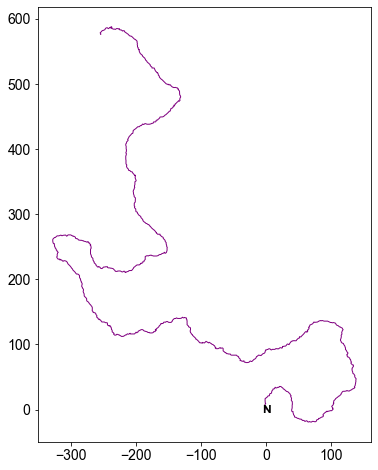

In [12]:
f = plt.figure(figsize=(8,8))
plt.axis([-map_size,map_size,-map_size,map_size])
plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
plt.plot(bee_coords[:T_outbound,0], bee_coords[:T_outbound,1], color='purple', lw=1)
plt.axis('scaled')
plt.show()

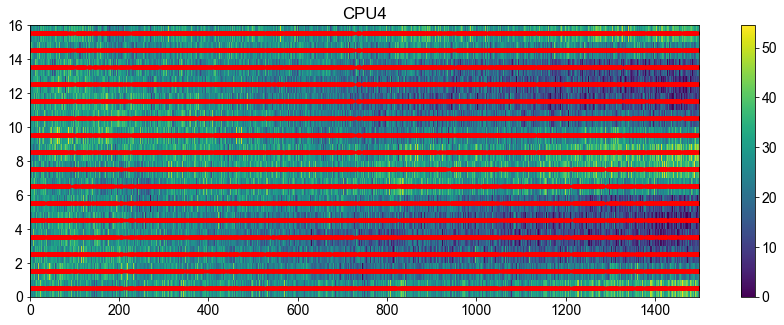

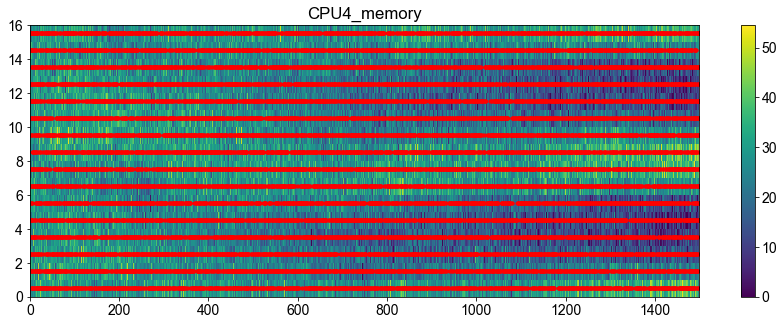

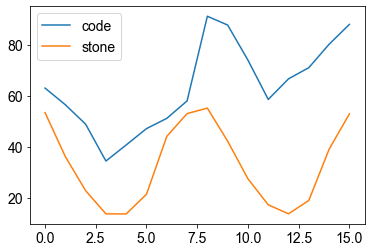

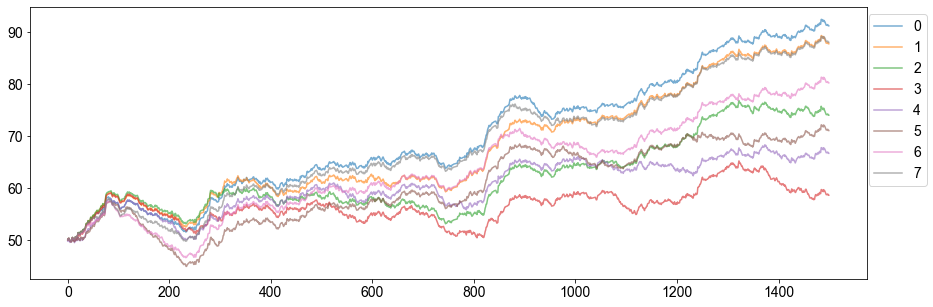

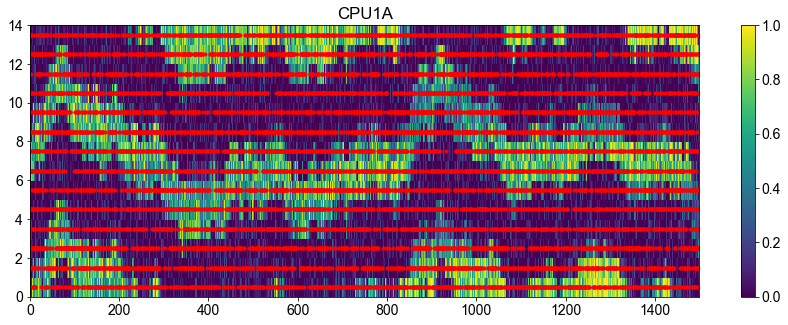

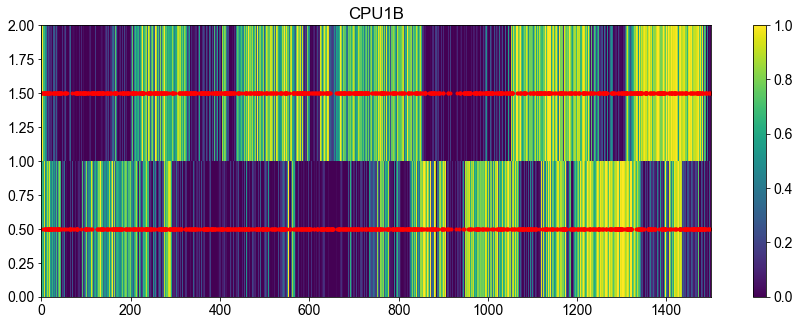

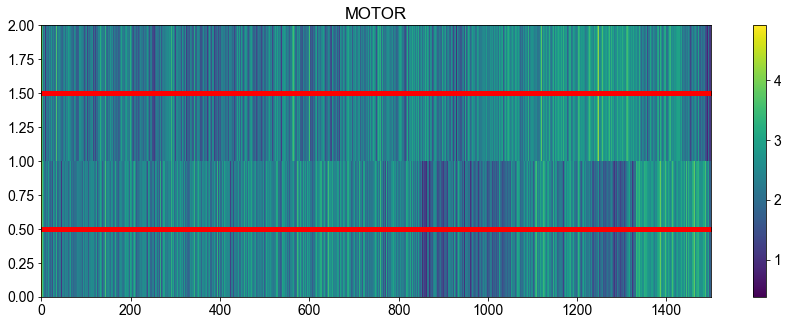

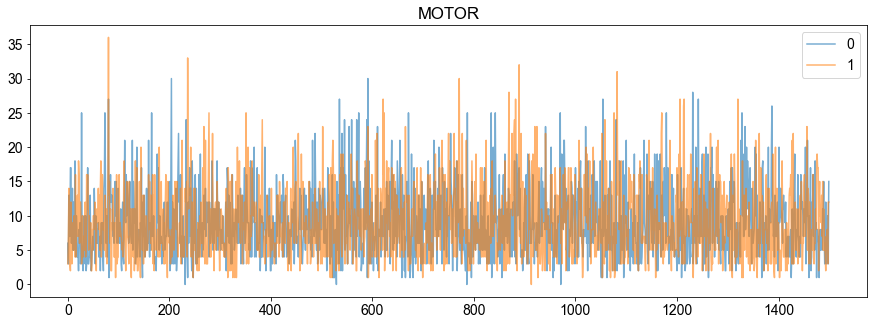

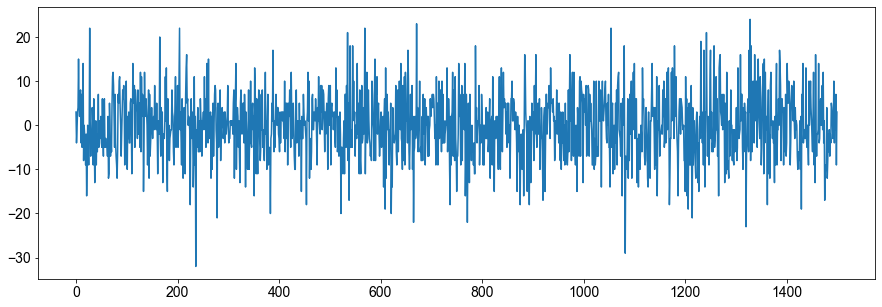

In [13]:
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, 60, SPM_CPU4, time_step, 
                                            title='CPU4',  figsize=(15,5), xlim=[0,T_outbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, 60, SPM_CPU4_MEMORY, time_step, 
                                            title='CPU4_memory',  figsize=(15,5), xlim=[0,T_outbound])

plt.plot(CPU4_memory, label='code')
plt.plot(cx_log.memory[:,T_outbound-1]*CPU4_memory.max(), label='stone')
plt.legend()
plt.show()
plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[:T_outbound,r+8], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
#plt.xlim([1400,1500])
plt.show()



cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[1:-1,:], 1, SPM_CPU1A, time_step,
                                            title='CPU1A',  figsize=(15,5), xlim=[0,T_outbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[[1,-1],:], 1, SPM_CPU1B, time_step, 
                                            title='CPU1B',  figsize=(15,5), xlim=[0,T_outbound])


motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
cx_spiking.plotting.plot_motors_cx_log_spikes(motors, motors.max(), SPM_MOTOR, time_step, min_rate=motors.min(), 
                                            title='MOTOR',  figsize=(15,5), xlim=[0,T_outbound])
MOTOR_spikes =  cx_spiking.inputs.get_spikes_rates(SPM_MOTOR, N_MOTOR, T_outbound, time_step)
plt.figure(figsize=(15,5))
plt.title('MOTOR')
for idx, r in enumerate(MOTOR_spikes):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot((MOTOR_spikes[0,:]-MOTOR_spikes[1,:]))
plt.show()

(1499,)


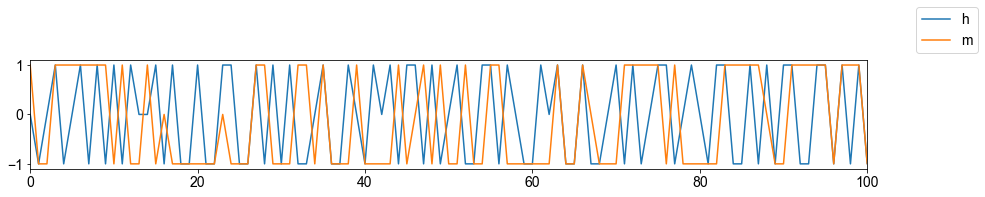

In [14]:
headings_diff = np.diff(heading_angles[:T_outbound], axis=0)
print(headings_diff.shape)
plt.figure(figsize=(15,2))
#plt.plot(headings_diff)
plt.plot(np.sign(headings_diff), label='h')
plt.plot(np.sign((MOTOR_spikes[0,:]-MOTOR_spikes[1,:])), label='m')
plt.xlim([0,100])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Inbound path

In [97]:
def get_next_velocity(heading, velocity, rotation, acceleration=0.1, drag=0.15):
    def thrust(theta, acceleration):
        return np.array([np.sin(theta), np.cos(theta)]) * acceleration
    v = velocity + thrust(heading, acceleration).flatten()
    v -= drag * v
    return v

In [125]:
net.restore('outbound')
new_heading_dir = np.zeros(T_inbound)
print(CPU4_memory_history[1497:1502,:])
print(heading_angles[1497:1502])
for ts in range(10):
    if ts % 50 == 0:
        print(ts)
    sim_timestep = T_outbound+ts
    print(sim_timestep)
    # prepare inputs
    
    #### motor response
    motor_responses = extract_spike_counts(SPM_MOTOR, (sim_timestep)*time_step*ms, time_step)
    rotation = np.sign(motor_responses[0] - motor_responses[1])
    #print(motor_responses, rotation)
    
    #### heading
    # previous heading
    prev_heading = np.array([heading_angles[sim_timestep-1]])
    # compute spikes based on old heading and rotation using fixed angle "step" of 22.5 degrees 
    new_heading = prev_heading + rotation * np.pi/8
    new_heading_dir[ts] = new_heading
    new_headings = cx_spiking.inputs.compute_headings(new_heading, N=N_TL2//2, vmin=5, vmax=100)
    new_headings = np.tile(new_headings, 2) 
    # save new heading
    headings[sim_timestep,:] = new_headings
    h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms, name='h_stimulus')
    
    #### velocity
    velocity = np.array(velocities[sim_timestep-1,:])
    updated_v = get_next_velocity(new_heading, velocity, rotation)
    new_flow = cx_spiking.inputs.compute_flow(new_heading, updated_v, baseline=50, 
                                              vmin=0, vmax=50, inbound=True)
    flow[sim_timestep,:] = new_flow
    f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms, name='h_stimulus')
    P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)', name='P_FLOW')

    


    # run newtork for a single timestep
    net.run(time_step*ms)

[[79.43865888 76.68874873 68.91812489 55.12552606 56.31952383 66.49301718
  73.20387335 80.62410889 80.70596404 73.84402521 62.38888956 55.3735132
  53.6005612  62.96896229 69.03160226 76.71721374]
 [79.46593161 76.71602146 68.94539762 55.15279879 56.34679656 66.52028991
  73.23114607 80.65138161 80.45596404 73.59402521 62.13888956 55.1235132
  53.3505612  62.71896229 68.78160226 76.46721374]
 [77.71593161 74.96602146 67.19539762 53.40279879 54.59679656 64.77028991
  71.48114607 78.90138161 78.70596404 73.7849343  62.32979865 55.31442229
  53.54147029 62.90987138 68.97251135 76.65812283]
 [77.46593161 74.71602146 66.94539762 53.15279879 54.34679656 64.52028991
  71.23114607 78.65138161 78.45596404 73.81220702 62.35707138 55.34169502
  53.56874302 62.93714411 68.99978408 76.68539556]
 [77.49320434 74.74329419 66.97267035 53.18007151 54.37406928 64.54756264
  71.2584188  78.67865434 78.54405928 73.90030226 62.44516662 55.42979026
  53.65683826 63.02523935 69.08787932 76.77349079]]
[-3.14

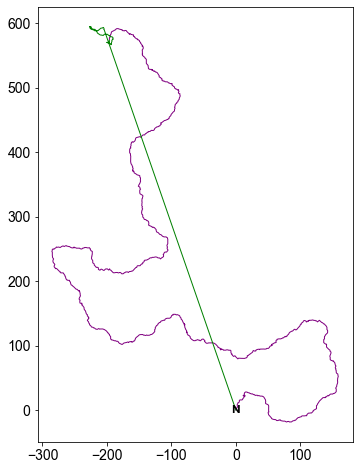

In [128]:
f = plt.figure(figsize=(8,8))
plt.axis([-map_size,map_size,-map_size,map_size])
plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
plt.plot(bee_coords[:T_outbound,0], bee_coords[:T_outbound,1], color='purple', lw=1)
plt.plot(bee_coords[T_outbound:,0], bee_coords[T_outbound:,1], color='green', lw=1)
plt.axis('scaled')
plt.show()

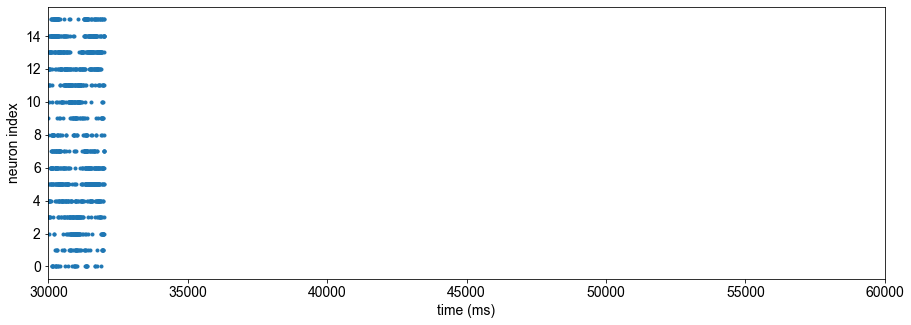

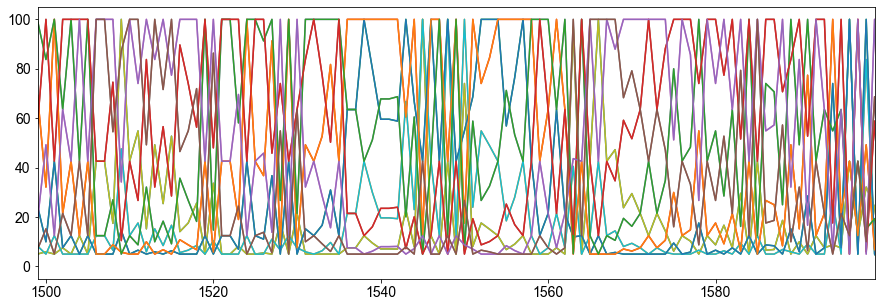

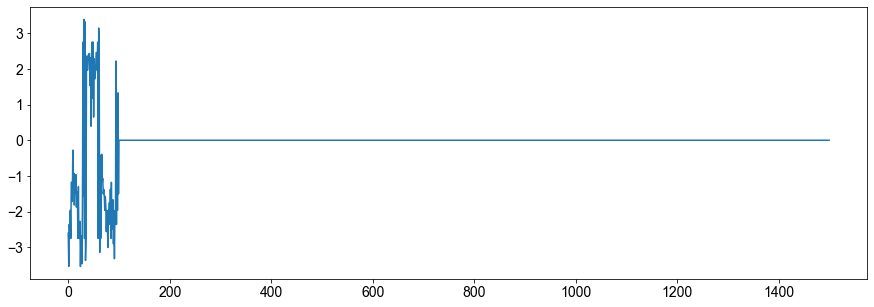

In [115]:
plt.figure(figsize=(15,5))
brian_plot(SPM_HEADING)
plt.xlim([29980,30000+20*T_inbound])
plt.show()

plt.figure(figsize=(15,5))
plt.plot(headings)
plt.xlim([1499,1499+100])
plt.show()

plt.figure(figsize=(15,5))
plt.plot(new_heading_dir)
plt.show()



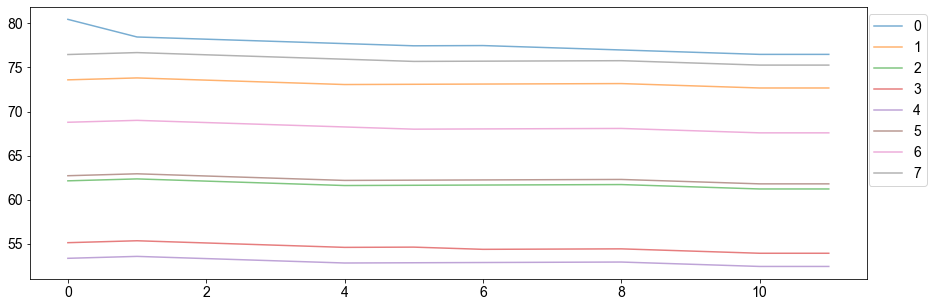

In [127]:
plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[1498:1510,r+8], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
#plt.xlim([1400,1500])
plt.show()

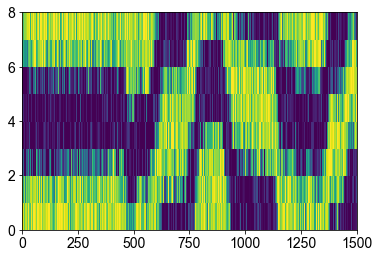

In [106]:
plt.pcolormesh(cx_log.tb1[:,T_outbound:], label='stone')
plt.show()



[]

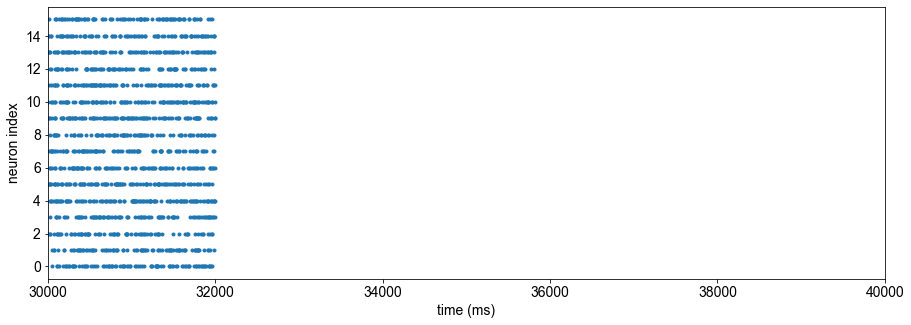

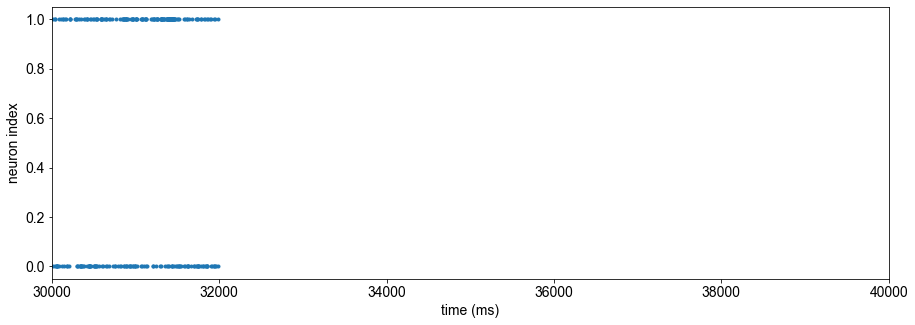

In [107]:
plt.figure(figsize=(15,5))
brian_plot(SPM_CPU4_MEMORY)
plt.xlim([30000,40000])
plt.plot()

plt.figure(figsize=(15,5))
brian_plot(SPM_TN2)
plt.xlim([30000,40000])
plt.plot()

